In [2]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import d2l
import random
import numpy as np
import pandas as pd

#### get the data

In [3]:
train_data0101 = pd.read_csv('train_crisis_nextday_balanced.csv')
train_data2020 = pd.read_csv('train_crisis20_balanced.csv')
#train_data_imbalanced01=pd.read_csv("whole_train_data_imblanced.csv")
test_data = pd.read_csv('test_data_imblanced.csv')

In [4]:
train_data2020.head()

,Unnamed: 0,Date,Global.Crisis.20,crr_DEXMXUS_lag40,crr_Poland_lag60,volatility_Denmark_lag40,crr_Denmark_lag40,volatility_Bonds_Greece_lag1,volatility_England_lag4,crr_DEXUSNZ_lag5,...,crr_Poland_lag40,crr_Japan_lag40,crr_Hong_Kong_lag40,crr_Israel_lag20,average_crisis_past20_Bonds_Hong.Kong,volatility_USD1MTD156N_lag60,average_crisis_past20_Hong_Kong,crr_Denmark_lag60,crr_Hungary_lag60,crr_Hungary_lag40
0,1,08/02/2006,0,-0.020392,0.160922,0.001677,0.040951,0.001383,0.000607,-0.011149,...,0.054134,0.028410,0.034412,-0.059759,0.0,0.009765,0.0,0.099218,0.065421,0.053299
1,2,12/01/2011,0,-0.024929,0.002799,0.001860,0.043124,0.012809,0.000368,-0.002629,...,0.007209,0.082466,0.046853,0.029836,0.0,0.000373,0.0,0.034261,-0.120412,-0.011822
2,3,03/05/2005,0,0.004545,-0.087980,0.002489,-0.049891,0.001225,0.000025,0.001792,...,-0.214132,-0.065442,0.015007,-0.005503,0.0,0.031157,0.0,0.035533,0.007614,-0.187226
3,4,22/08/2005,0,-0.007513,0.137533,0.008222,0.090677,0.001122,0.000026,-0.011556,...,0.098749,0.087563,0.062232,0.029011,0.0,0.023380,0.0,0.097642,0.210157,0.148640
4,5,15/04/2010,0,-0.051722,0.070445,0.013674,0.116935,0.004566,0.000363,0.005503,...,0.177511,0.072449,0.090975,-0.003427,0.0,0.011096,0.0,0.126818,0.127747,0.205749


In [5]:
print(train_data0101.shape)
print(test_data.shape)

(3923, 70)
(693, 71)


In [6]:
#Scrambled data
train_data01 =train_data0101.reindex(np.random.permutation(train_data0101.index))
train_data20 =train_data2020.reindex(np.random.permutation(train_data2020.index))

In [7]:
#get the features
features = [x for x in test_data.columns if x not in ['Date','Global.Crisis',
                                             'Global.Crisis.20']]
features = features[1:]

In [8]:
# normalize the data to obey n(0,1)
all_features1=train_data01[features]
all_features2=train_data20[features]
all_features_test0=test_data[features]
all_features01=train_data01[features]
all_features20=train_data20[features]
all_features_test=test_data[features]

In [11]:
for i in features:
    all_features01.loc[:,i]=(all_features1.loc[:,i]-all_features1.loc[:,i].mean())/all_features1.loc[:,i].std()
    all_features20.loc[:,i]=(all_features2.loc[:,i]-all_features2.loc[:,i].mean())/all_features2.loc[:,i].std()
    all_features_test.loc[:,i]=(all_features_test0.loc[:,i]-all_features_test0.loc[:,i].mean())/all_features_test0.loc[:,i].std()

In [12]:
#n_train01 = train_data01.shape[0]
train_features01 = torch.tensor(all_features01.values.astype(np.float32))
train_features20 = torch.tensor(all_features20.values.astype(np.float32))
test_features = torch.tensor(all_features_test.values.astype(np.float32))
#train_labels = torch.tensor(train_data01["Global.Crisis"].values.astype(np.float32)).reshape((-1,1))
train_labels01 = torch.tensor(np.array(train_data01["Global.Crisis"].values),dtype = torch.float64).type(torch.LongTensor)
train_labels20 = torch.tensor(np.array(train_data20["Global.Crisis.20"].values),dtype = torch.float64).type(torch.LongTensor)
test_labels=torch.tensor(np.array(test_data["Global.Crisis"].values),dtype = torch.float64).type(torch.LongTensor)
test_labels20=torch.tensor(np.array(test_data["Global.Crisis.20"].values),dtype = torch.float64).type(torch.LongTensor)

## training

In [13]:
def dropout(X, drop_prob):
    assert 0 <= drop_prob <= 1
    # In this case, all elements are dropped out
    if drop_prob == 1:
        return torch.zeros_like(X)
    mask = (torch.FloatTensor(X.shape).uniform_(0, 1) > drop_prob).float()
    return mask * X / (1.0 - drop_prob)

In [14]:
# Set three types of net: one hidden layer, two hidden layers, three hidden layers
class Net1(nn.Module):
    def __init__(self, num_inputs, num_outputs ,num_hiddens01,active_function,drop_prob,is_training = True):
        super(Net1, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hiddens01 = num_hiddens01
        
        self.is_training = is_training 
        
        self.linear_1 = nn.Linear(num_inputs, num_hiddens01)
        self.linear_2 = nn.Linear(num_hiddens01, num_outputs)
        if active_function=="ReLU":
            self.active = nn.ReLU()
        elif active_function=="sigmoid":
            self.active = nn.Sigmoid()
        elif active_function=="Tanh":
            self.active = nn.Tanh()
    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H1= self.linear_1(X)
        nn.BatchNorm1d(self.num_hiddens01)
        H1 = self.active(H1)
        # Use dropout only when training the model
        if self.is_training == True:
            # Add a dropout layer after the first fully connected layer
            H1 = dropout(H1, drop_prob)
        H2 = self.linear_2(H1)
        H2 = F.softmax(H2,dim=1)
        return H2
    
class Net2(nn.Module):
    def __init__(self, num_inputs, num_outputs ,num_hiddens01, num_hiddens02,active_function,drop_prob,is_training = True):
        super(Net2, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hiddens01 = num_hiddens01
        self.num_hiddens02 = num_hiddens02
        
        self.is_training = is_training 
        
        self.linear_1 = nn.Linear(num_inputs, num_hiddens01)
        self.linear_2 = nn.Linear(num_hiddens01, num_hiddens02)
        self.linear_3 = nn.Linear(num_hiddens02, num_outputs)
        if active_function=="ReLU":
            self.active = nn.ReLU()
        elif active_function=="sigmoid":
            self.active = nn.Sigmoid()
        elif active_function=="Tanh":
            self.active = nn.Tanh()
    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H1= self.linear_1(X)
        nn.BatchNorm1d(self.num_hiddens01)
        H1 = self.active(H1)
        # Use dropout only when training the model
        if self.is_training == True:
            # Add a dropout layer after the first fully connected layer
            H1 = dropout(H1, drop_prob)
        H2 = self.linear_2(H1)
        nn.BatchNorm1d(self.num_hiddens02)
        H2 = self.active(H2)
        if self.is_training == True :
            # Add a dropout layer after the first fully connected layer
            H2 = dropout(H2, drop_prob)
        H3 = self.linear_3(H2)
        H3 = F.softmax(H3,dim=1)
        return H3

class Net3(nn.Module):
    def __init__(self, num_inputs, num_outputs ,num_hiddens01, num_hiddens02,num_hiddens03,active_function,drop_prob,is_training = True):
        super(Net3, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hiddens01 = num_hiddens01
        self.num_hiddens02 = num_hiddens02
        self.num_hiddens03 = num_hiddens03
        
        self.is_training = is_training 
        
        self.linear_1 = nn.Linear(num_inputs, num_hiddens01)
        self.linear_2 = nn.Linear(num_hiddens01, num_hiddens02)
        self.linear_3 = nn.Linear(num_hiddens02, num_hiddens03)
        self.linear_4 = nn.Linear(num_hiddens03, num_outputs)
        if active_function=="ReLU":
            self.active = nn.ReLU()
        elif active_function=="sigmoid":
            self.active = nn.Sigmoid()
        elif active_function=="Tanh":
            self.active = nn.Tanh()
    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H1= self.linear_1(X)
        nn.BatchNorm1d(self.num_hiddens01)
        H1 = self.active(H1)
        # Use dropout only when training the model
        if self.is_training == True:
            # Add a dropout layer after the first fully connected layer
            H1 = dropout(H1, drop_prob)
        H2 = self.linear_2(H1)
        nn.BatchNorm1d(self.num_hiddens02)
        H2 = self.active(H2)
        if self.is_training == True :
            # Add a dropout layer after the first fully connected layer
            H2 = dropout(H2, drop_prob)
        H3 = self.linear_3(H2)
        nn.BatchNorm1d(self.num_hiddens03)
        H3 = self.active(H3)
        if self.is_training == True :
            # Add a dropout layer after the first fully connected layer
            H3 = dropout(H3, drop_prob)
        H4 = self.linear_4(H3)
        H4 = F.softmax(H4,dim=1)
        return H4

In [15]:
loss = nn.CrossEntropyLoss()
def get_net(num_inputs, num_outputs ,num_hiddens01, num_hiddens02,num_hiddens03,active_function,drop_prob):
    if( num_hiddens01<num_hiddens02 or num_hiddens02 < num_hiddens03):
        print("Wrong Hidden layers")
        net=False
    elif (num_hiddens02==0):
        net=Net1(num_inputs, num_outputs ,num_hiddens01,active_function,drop_prob)
    elif (num_hiddens03==0):
        net=Net2(num_inputs, num_outputs ,num_hiddens01,num_hiddens02,active_function,drop_prob)
    else:
        net=Net3(num_inputs, num_outputs ,num_hiddens01,num_hiddens02,num_hiddens03,active_function,drop_prob)
    return net


In [16]:
def evaluate_accuracy(net,features,labels):
    acc_sum,n = torch.tensor([0],dtype=torch.float32),0
    with torch.no_grad():
        outputs=net.forward(features)
        st=torch.argmax(outputs,dim=1) == labels
        acc_sum += torch.sum(st).float()
        n += labels.shape[0]
    return acc_sum.item()/(n)
def get_loss(net,features,labels):
    outputs=net.forward(features)
    l=loss(outputs,labels)
    return l

In [17]:
# trainning
def train(net,i,train_feature, train_label, test_feature, test_label,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_feature,train_label), batch_size, shuffle=True)
    optimizer = torch.optim.Adam(net.parameters(),lr= learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        train_l = torch.tensor([0.0],dtype=torch.float32)
        train_acc = torch.tensor([0.0],dtype=torch.float32)
        for X, y in train_iter:
            optimizer.zero_grad()
            outputs = net.forward(X)
            l = loss(outputs,y) 
            l.backward()
            optimizer.step()
            train_l=l
        train_acc=evaluate_accuracy(net,train_feature,train_label)
        #print("Train Accuracy of %d for epoch %d is"% (i,epoch),train_acc)
        #print("Loss:",train_l)
        train_ls.append(train_acc)
        #loss_ls.append(train_l_sum/n)
        if test_label is not None:
            test_acc = evaluate_accuracy(net,test_feature,test_label)
            test_ls.append(test_acc)
            #print("validation Accuracy of %d for epoch %d is"% (i,epoch),test_acc)
    l=get_loss(net,train_feature,train_label)
    #print("Loss:",l)
    acc_train=evaluate_accuracy(net,train_feature,train_label)
    #print("Train Accuracy of fold %d is"% i,evaluate_accuracy(net,train_feature,train_label))
    if test_label is not None:
        acc_test=evaluate_accuracy(net,test_feature,test_label)
        #print("Test Accuracy of fold %d is"% i,evaluate_accuracy(net,test_feature,test_label))
    return train_ls, test_ls ,l
    #return acc_train acc_test

## K-fold Validation

In [18]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [19]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size,num_inputs, num_outputs ,num_hiddens01, num_hiddens02,num_hiddens03,active_function,drop_prob):
    train_l_sum, valid_l_sum ,loss_sum= 0, 0,0
    for i in range(k):
        #print(i,"fold")
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(num_inputs, num_outputs ,num_hiddens01, num_hiddens02,num_hiddens03,active_function,drop_prob)
        if net==False:break
        train_ls, valid_ls,l = train(net,i, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        loss_sum+=l
        #if i in [0,1,2,3,4]:
        if i ==5:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'accuracy',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        #print('fold %d, train accuracy: %f, valid accuracy: %f' % (i, train_ls[-1], valid_ls[-1]))#,loss_ls[-1]))
    return train_l_sum / k, valid_l_sum / k ,loss_sum/k

## Nextday model

### Model selection

* The parameter we need to choose from is:
  - num_epochs:20
  - learning rate(lr):0.001,0.01,0.1,1,10
  - weight_decay:
  - batch_size:16，32，64，128，256
  - number of hidden layers:1-3
  - number of nets:
      - num_hiddens01:2-68
      - num-hiddens02:2-num_hiddens01
      - num-hiddens03:2-num_hiddens02
  - active_function:"ReLU","sigmoid","Tanh"
  - dropout rate(drop_prob):0,0.1,0.3,0.5
* Evaluation methods: Loss 

#### choose batch size

In [265]:
#choose batch size
best_score=1
k, num_epochs, lr, weight_decay, batch_size = 5, 20,0.001, 0.1, 64
active_function,drop_prob="ReLU",0.1
num_hiddens01, num_hiddens02,num_hiddens03=30,20,0
for batch_size in [16,32,64,128]:
    train_l, valid_l,l = k_fold(k, train_features01, train_labels01, num_epochs, lr,
                          weight_decay, batch_size,num_inputs, num_outputs,
                          num_hiddens01, num_hiddens02,num_hiddens03,active_function,drop_prob)
    #print("%d batch"%batch_size)
    #print('%d-fold validation: avg train accuracy: %f, avg valid accuracy: %f,avg final loss%f'% (k, train_l, valid_l,l))
    if l<best_score:
        best_score=l
        best_size=batch_size
print("best batchsize is: ", best_size)

best batchsize is:  32


#### choose best numbers of hidden layers

In [254]:
num_inputs = train_features.shape[1]
num_outputs=2
best_score=1
k, num_epochs, lr, weight_decay, batch_size = 5, 20,0.001, 0.1, 32
active_function,drop_prob="ReLU",0.1
bestchoice=[0,0,0]
#num_hiddens01, num_hiddens02,num_hiddens03=30,20,0
for num_hiddens01 in range(0,65,5):
    for num_hiddens02 in range(0,num_hiddens01,3):
        if num_hiddens02==1:continue
        for num_hiddens03 in range(0,num_hiddens02,2):
            if num_hiddens03==1:continue
            train_l, valid_l,l = k_fold(k, train_features01, train_labels01, num_epochs, lr,
                          weight_decay, batch_size,num_inputs, num_outputs,
                          num_hiddens01, num_hiddens02,num_hiddens03,active_function,drop_prob)
            #print(num_hiddens01,num_hiddens02,num_hiddens03)
            #print('%d-fold validation: avg train accuracy: %f, avg valid accuracy: %f,avg final loss%f'% (k, train_l, valid_l,l))
            if l<0.01:
                print("loss < 0.01:")
                print(num_hiddens01,num_hiddens02,num_hiddens03)
            if l<best_score:
                best_score=l
                bestchoice=[num_hiddens01,num_hiddens02,num_hiddens03]
#print("best choice is",bestchoice) 
print(best_score)
print(bestchoice)

tensor(0.1307, grad_fn=<DivBackward0>)
[50, 39, 24]


#### choose learning rate ,active funciton and drop_prob

In [270]:
num_inputs = train_features.shape[1]
num_outputs=2
best_score=1
k, num_epochs, weight_decay, batch_size = 5, 20, 0.1, 32
bestchoice=[0,0,0]
num_hiddens01, num_hiddens02,num_hiddens03=50,39,24
for lr in [0.001,0.004,0.01,0.1,1,10]:
    for active_function in ["ReLU","sigmoid","Tanh"]:
        for drop_prob in [0,0.1,0.3,0.5]:
            train_l, valid_l,l = k_fold(k, train_features01, train_labels01, num_epochs, lr,
                          weight_decay, batch_size,num_inputs, num_outputs,
                          num_hiddens01, num_hiddens02,num_hiddens03,active_function,drop_prob)
            #print(lr,active_function,drop_prob)
            #print('%d-fold validation: avg train accuracy: %f, avg valid accuracy: %f,avg final loss%f'% (k, train_l, valid_l,l))
            if l<0.01:
                print("loss < 0.01:")
            if l<best_score:
                best_score=l
                bestchoice01=[lr,active_function,drop_prob]
print(bestchoice01) 

[0.004, 'Tanh', 0.1]


##### Here we the parameters we choose is shown below:
    * learning rate:0.004
    * dropout rate:0.1
    * weight decay:0.1
    * active_function: "Tanh"
    * layers:3
    * hidden cell numbers: 50,39,34
    * 5-fold
    * numbers of epochs: 20

### predict

In [20]:
def train_and_pred(train_feature, test_feature, train_label,test_label,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(num_inputs, num_outputs ,num_hiddens01, num_hiddens02,num_hiddens03,active_function,drop_prob)
    train_ls, _ ,l= train(net,0,train_feature, train_label, None,None,num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'accuracy')
    print('train Accuracy %f' % train_ls[-1])
    # Apply the network to the test set
    preds = net(test_feature).detach().numpy()
    acc=evaluate_accuracy(net,test_feature,test_label)
    print("test accuracy",acc)
    return preds
    # Reformat it for export to Kaggle
    #test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])

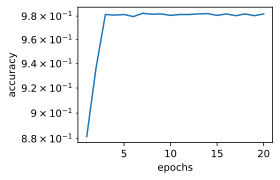

train Accuracy 0.981902
test accuracy 0.5108225108225108


In [21]:
num_inputs = train_features01.shape[1]
num_outputs=2
k, num_epochs, weight_decay, batch_size = 5, 20, 0.1, 32
num_hiddens01, num_hiddens02,num_hiddens03=50,39,24
lr,active_function,drop_prob = 0.0004,"Tanh",0.1
pre=train_and_pred(train_features01, test_features, train_labels01,test_labels,num_epochs, lr, weight_decay, batch_size)
pr=np.array(pre) 
pred=pr[:,1]

<Figure size 252x180 with 0 Axes>

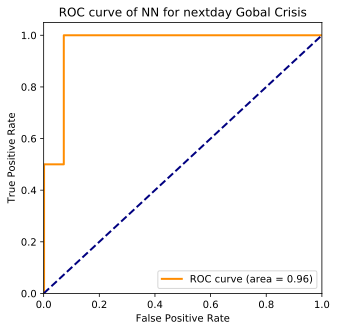

In [22]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
fpr, tpr, threshold = roc_curve(test_labels,pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of NN for nextday Gobal Crisis')
plt.legend(loc="lower right")
plt.show()
#print("pred",y_pred)

In [23]:
confusion_matrix((pred>0.95).astype("int"),test_labels)

array([[629,   0],
       [ 62,   2]], dtype=int64)

In [56]:
threshold.mean()

0.988198

In [24]:
confusion_matrix((pred> 0.5).astype('int'),test_labels)

array([[352,   0],
       [339,   2]], dtype=int64)

## Next 20 days 

### Model selection

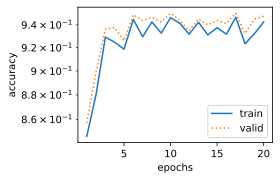

fold 0, train accuracy: 0.942602, valid accuracy: 0.947704
fold 1, train accuracy: 0.921556, valid accuracy: 0.918367
fold 2, train accuracy: 0.929209, valid accuracy: 0.922194
fold 3, train accuracy: 0.936543, valid accuracy: 0.910714
fold 4, train accuracy: 0.934630, valid accuracy: 0.942602
5-fold validation: avg train accuracy: 0.932908, avg valid accuracy: 0.928316,avg final loss0.482135


In [294]:
num_inputs = train_features.shape[1]
num_outputs=2
k, num_epochs, lr, weight_decay, batch_size = 5, 20,0.001, 0.1, 64
num_hiddens01, num_hiddens02,num_hiddens03,active_function,drop_prob,=30,20,0,"ReLU",0.1
train_l, valid_l,l = k_fold(k, train_features20, train_labels20, num_epochs, lr,
                          weight_decay, batch_size,num_inputs, num_outputs ,num_hiddens01, num_hiddens02,num_hiddens03,active_function,drop_prob)
print('%d-fold validation: avg train accuracy: %f, avg valid accuracy: %f,avg final loss%f'% (k, train_l, valid_l,l))
    

#### choose batch size

In [313]:
#choose batch size
best_score=1
k, num_epochs, lr, weight_decay, batch_size = 5, 40,0.001, 0.1, 64
active_function,drop_prob="ReLU",0.1
num_hiddens01, num_hiddens02,num_hiddens03=30,20,0
for batch_size in [16,32,64,128]:
    train_l, valid_l,l = k_fold(k, train_features20, train_labels20, num_epochs, lr,
                          weight_decay, batch_size,num_inputs, num_outputs,
                          num_hiddens01, num_hiddens02,num_hiddens03,active_function,drop_prob)
    #print("%d batch"%batch_size)
    #print('%d-fold validation: avg train accuracy: %f, avg valid accuracy: %f,avg final loss%f'% (k, train_l, valid_l,l))
    if l<best_score:
        best_score=l
        best_size=batch_size
print("best batchsize is: ", best_size)

best batchsize is:  64


In [312]:
num_inputs = train_features.shape[1]
num_outputs=2
best_score=1
k, num_epochs, lr, weight_decay, batch_size = 5, 20,0.001, 0.1, 64
active_function,drop_prob="ReLU",0.1
bestchoice=[0,0,0]
#num_hiddens01, num_hiddens02,num_hiddens03=30,20,0
for num_hiddens01 in [50,55,60,65]:
    for num_hiddens02 in range(15,65,3):
        if num_hiddens02==1:continue
        for num_hiddens03 in range(0,num_hiddens02,2):
            if num_hiddens03==1:continue
            train_l, valid_l,l = k_fold(k, train_features20, train_labels20, num_epochs, lr,
                          weight_decay, batch_size,num_inputs, num_outputs,
                          num_hiddens01, num_hiddens02,num_hiddens03,active_function,drop_prob)
            #print(num_hiddens01,num_hiddens02,num_hiddens03)
            #print('%d-fold validation: avg train accuracy: %f, avg valid accuracy: %f,avg final loss%f'% (k, train_l, valid_l,l))
            if l<0.01:
                print("loss < 0.1:")
                print(num_hiddens01,num_hiddens02,num_hiddens03)
            if l<best_score:
                best_score=l
                bestchoice=[num_hiddens01,num_hiddens02,num_hiddens03]
print("best choice is",bestchoice)   

[50, 33, 24]


In [314]:
num_inputs = train_features.shape[1]
num_outputs=2
best_score=1
k, num_epochs, weight_decay, batch_size = 5, 20, 0.1, 64
bestchoice=[0,0,0]
num_hiddens01, num_hiddens02,num_hiddens03=50,33,24
for lr in [0.001,0.004,0.01,0.1,1,10]:
    for active_function in ["ReLU","sigmoid","Tanh"]:
        for drop_prob in [0,0.1,0.3,0.5]:
            train_l, valid_l,l = k_fold(k, train_features20, train_labels20, num_epochs, lr,
                          weight_decay, batch_size,num_inputs, num_outputs,
                          num_hiddens01, num_hiddens02,num_hiddens03,active_function,drop_prob)
            #print(lr,active_function,drop_prob)
            #print('%d-fold validation: avg train accuracy: %f, avg valid accuracy: %f,avg final loss%f'% (k, train_l, valid_l,l))
            if l<0.01:
                print("loss < 0.01:")
            if l<best_score:
                best_score=l
                bestchoice01=[lr,active_function,drop_prob]
print(bestchoice01) 

[0.001, 'Tanh', 0.1]


##### Here we the parameters we choose is shown below:
    * learning rate:0.001
    * dropout rate:0.1
    * weight decay:0.1
    * active_function: "Tanh"
    * layers:3
    * hidden cell numbers: 50,33,34
    * 5-fold
    * numbers of epochs: 20

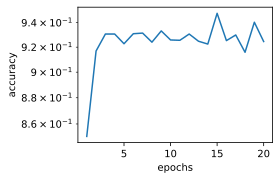

train Accuracy 0.924548
test accuracy 0.5858585858585859


In [28]:
num_inputs = train_features20.shape[1]
num_outputs=2
k, num_epochs, weight_decay, batch_size = 5, 20, 0.1, 64
num_hiddens01, num_hiddens02,num_hiddens03=50,33,24
lr,active_function,drop_prob = 0.001,"Tanh",0.1
pre20=train_and_pred(train_features20, test_features, train_labels20,test_labels20,num_epochs, lr, weight_decay, batch_size)
pr=np.array(pre20) 
pred20=pr[:,1]

<Figure size 252x180 with 0 Axes>

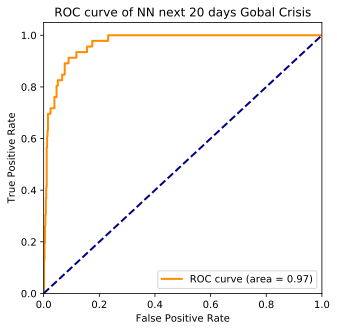

In [29]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
fpr, tpr, threshold = roc_curve(test_labels20,pred20)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of NN next 20 days Gobal Crisis')
plt.legend(loc="lower right")
plt.show()
#print("pred",y_pred)

In [59]:
confusion_matrix((pred20>0.75).astype("int"),test_labels20)

array([[506,   1],
       [141,  45]], dtype=int64)

In [35]:
confusion_matrix((pred20> 0.5).astype('int'),test_labels20)

array([[358,   0],
       [289,  46]], dtype=int64)